In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
from statannotations.Annotator import Annotator
from matplotlib.ticker import FormatStrFormatter

from game import *
from utils import *
from plots import *
from agents import *
from T4T import *
from nni_pop import *

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [6]:
def rerun(agents, args, t4tSeedStart=0):
    dfs = []
    for i in range(args['nTest']):
        print(f'test {i}')
        for agent in agents:
            agent.reinitialize(args['player'])
        df = run(agents, nGames=args['nGames'], opponent=args["opponent"], t4tSeed=t4tSeedStart+i).query("ID in @IDs")
        df['t4tSeed'] = [t4tSeedStart+i for _ in range(df.shape[0])]
        dfs.append(df)
    data = pd.concat(dfs, ignore_index=True)
    return data

In [7]:
def tTestAndPlot(emp, sim, args, dependent):
    player = args['player']
    opponent = args['opponent']
    gameFinal = 14 - args['nFinal']
    player2 = 'trustee' if player=='investor' else 'investor'
    emp = emp.query('game>@gameFinal')
    sim = sim.query('game>@gameFinal')
    yticks = ((0, 0.2, 0.4, 0.6, 0.8, 1.0)) if dependent=='generosity' else ((0, 5, 10, 15))

    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=((6.38, 2)))
    sns.violinplot(data=emp, x="orientation", y=dependent, order=["proself", "prosocial"], ax=axes[0], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
    annot = Annotator(pairs=[("proself", "prosocial")], data=emp, x='orientation', y=dependent, order=["proself", "prosocial"], ax=axes[0], plot='violinplot')
    annot.configure(test="t-test_ind", loc='inside', verbose=1).apply_test().annotate()
    axes[0].set(xlabel=None, title=f'humans vs {opponent} {player2}', yticks=yticks)

    sns.violinplot(data=sim, x="orientation", y=dependent, order=["proself", "prosocial"], ax=axes[1], palette=palette[2:4], saturation=1, inner='quartile', cut=0, bw=0.2)
    annot = Annotator(pairs=[("proself", "prosocial")], data=sim, x='orientation', y=dependent, order=["proself", "prosocial"], ax=axes[1], plot='violinplot')
    annot.configure(test="t-test_ind", loc='inside', verbose=1).apply_test().annotate()
    axes[1].set(xlabel=None, ylabel=None, title=f'agent vs {opponent} {player2}', yticks=yticks)

    sns.despine(fig=fig, ax=axes, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
    plt.tight_layout()
    fig.savefig(f"plots/{args['architecture']}_vs_{opponent}_{player2}_{dependent}.png", dpi=600)

In [8]:
def LTPlot(agents, sim, args):
    player2 = 'trustee' if args['player']=='investor' else 'investor'
    IDs = [agent.ID for agent in agents]
    for ID in IDs:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=((6.38, 2)))
        sns.histplot(data=sim.query("ID==@ID"), x='game', y='generosity', bins=(15, 11), binrange=((0, args['nGames']),(0, 1)), ax=axes, color=palette[0])
        ax2 = axes.twinx()
        sns.lineplot(data=sim.query("ID==@ID"), x='game', y='coins', ax=ax2, color=palette[1])
        axes.set(title=f'{ID} vs {args["opponent"]} trustee',
            xlabel='Game', ylabel='Generosity', xticks=((0,5,10,15)), yticks=((0.0, 0.2, 0.4, 0.6, 0.8, 1.0)))
        ax2.set(ylabel='Score', yticks=((3,6,9,12,15)))
        plt.tight_layout()
        fig.savefig(f"plots/{ID}_vs_{opponent}_{player2}_LT.png", dpi=600)
        plt.close("all")

In [9]:
def generalizePlot(agents, sim, args):
    IDs = [agent.ID for agent in agents]
    nTrain = args['nTrain']
    for ID in IDs:
        testT4T = sim['t4tSeed'].max()
        S1 = sim.query('ID==@ID & t4tSeed<@nTrain')
        S2 = sim.query('ID==@ID & t4tSeed>=@nTrain')
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((6.38, 3)))
        sns.histplot(data=S1, x='game', y='generosity', bins=(15, 11), binrange=((0, args['nGames']),(0, 1)), ax=axes[0], color=palette[0])
        ax2 = axes[0].twinx()
        sns.lineplot(data=S1, x='game', y='coins', ax=ax2, color=palette[1])
        axes[0].set(title=f'{ID} vs {args["opponent"]} trustee', xlabel='Game', ylabel='Generosity', yticks=((0.0, 0.2, 0.4, 0.6, 0.8, 1.0)))
        ax2.set(ylabel='Score', yticks=((3,6,9,12,15)))
        sns.histplot(data=S2, x='game', y='generosity', bins=(15, 11), binrange=((0, args['nGames']),(0, 1)), ax=axes[1], color=palette[0])
        ax3 = axes[1].twinx()
        sns.lineplot(data=S2, x='game', y='coins', ax=ax3, color=palette[1])
        axes[1].set(title=f'{ID} vs {args["opponent"]} trustee', xlabel='Game', ylabel='Generosity', yticks=((0.0, 0.2, 0.4, 0.6, 0.8, 1.0)))
        ax3.set(ylabel='Score', yticks=((3,6,9,12,15)))
        plt.tight_layout()
        fig.savefig(f"plots/{ID}_generalize.png", dpi=600)
        plt.close("all")

In [25]:
f = open('data/IBLpop')
result = json.load(f)
min_loss = 1000
params = {}
for trial in result:
    loss = float(trial['value'])
    if loss <= min_loss:
        min_loss = loss
        params = trial['parameter']
print(params, min_loss)

{'popSeed': 59, 'decay': 0.4, 'sigma': 0.23, 'thrA': -1.6500000000000001, 'gamma': 0.09} 0.410132259919494


# DQN vs Greedy Trustee

In [30]:
f = open('fixed_space_pop.json')
params = json.load(f)
    
params2 = {
    "popSeed": 296,
    "tau": 19.1,
    "alpha": 0.02,
    "gamma": 0.71
}

args = params | params2

In [27]:
agents = makePopulation(args)
IDs = [agent.ID for agent in agents]

rng = args['popSeed']
dfs = []
for i in range(args['nIter']+1):
    for agent in agents: agent.reinitialize(args['player'])
    df = run(agents, nGames=args['nGames'], opponent=args["opponent"], t4tSeed=i).query("ID in @IDs")
    df['t4tSeed'] = [i for _ in range(df.shape[0])]
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

In [31]:
pop, selected = selectLearners(agents, data)
sim, nProself, nProsocial = addLabel(pop, selected, args)
print(f"proself {nProself}, prosocial {nProsocial}")
sim.to_pickle(f"data/{params['architecture']}_vs_greedy_trustee_violin.pkl")

124 agents selected
proself 74, prosocial 50


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:3.526e-01 t=-9.302e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:1.082e-01 t=1.607e+00


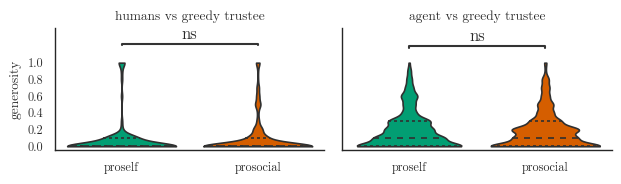

In [32]:
player = args['player']
opponent = args['opponent']
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player==@player & opponent==@opponent')
tTestAndPlot(emp, sim, args, 'generosity')

In [33]:
generalizePlot(pop, sim, args)

In [56]:
# for agent in pop:
#     aid = agent.ID
#     print(agent.ID, agent.w_i, agent.w_o)
#     print(sim.query("ID==@aid")['orientation'].unique())

In [18]:
params = {
    "architecture": "DQN",
    "player": "investor",
    "opponent": "greedy",
    "nAgents": 200,
    "nIter": 3,
    'nGames': 15,
    "explore": 'linear',
    "update": 'Q-learning',
    "w_s": 1,
    "w_o": 0.3,
    "w_i": 0.3,
    "nFinal": 3,
    "optimize_target": 'final',
    'overlap_test': 'ks',
    "popSize": 30,
    'tau':0,
    'nNeurons':50,
}

params2 = {
    "popSeed": 356,
    "alpha": 0.002,
    "gamma": 0.1
}

args = params | params2

In [19]:
agents = makePopulation(args)
IDs = [agent.ID for agent in agents]

rng = args['popSeed']
dfs = []
for i in range(args['nIter']+1):
    for agent in agents: agent.reinitialize(args['player'])
    df = run(agents, nGames=args['nGames'], opponent=args["opponent"], t4tSeed=i).query("ID in @IDs")
    df['t4tSeed'] = [i for _ in range(df.shape[0])]
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

In [20]:
pop, selected = selectLearners(agents, data)
sim, nProself, nProsocial = addLabel(pop, selected, args)
print(f"proself {nProself}, prosocial {nProsocial}")
sim.to_pickle(f"data/{params['architecture']}_vs_greedy_trustee_violin.pkl")

74 agents selected
proself 38, prosocial 36


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:3.526e-01 t=-9.302e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:9.893e-03 t=-2.581e+00


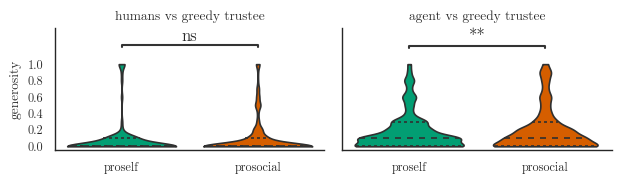

In [21]:
player = args['player']
opponent = args['opponent']
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player==@player & opponent==@opponent')
tTestAndPlot(emp, sim, args, 'generosity')

In [17]:
generalizePlot(pop, sim, args)

# IBL vs Greedy Trustee

In [29]:
params = {
    "architecture": "IBL",
    "player": "investor",
    "opponent": "greedy",
    "nAgents": 200,
    "nIter": 3,
    'nGames': 15,
    "explore": 'linear',
    "update": 'Q-learning',
    "w_s": 1,
    "w_o": 0.3,
    "w_i": 0.3,
    "nFinal": 3,
    "optimize_target": 'final',
    'overlap_test': 'rmse',
    "popSize": 30,
    "tau":0,
}
    
params2 = {'popSeed': 59, 'decay': 0.4, 'sigma': 0.23, 'thrA': -1.65, 'gamma': 0.09}

args = params | params2

In [30]:
agents = makePopulation(args)
IDs = [agent.ID for agent in agents]

rng = args['popSeed']
dfs = []
for i in range(args['nIter']+1):
    for agent in agents: agent.reinitialize(args['player'])
    df = run(agents, nGames=args['nGames'], opponent=args["opponent"], t4tSeed=i).query("ID in @IDs")
    df['t4tSeed'] = [i for _ in range(df.shape[0])]
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

In [31]:
pop, selected = selectLearners(agents, data)
sim, nProself, nProsocial = addLabel(pop, selected, args)
print(f"proself {nProself}, prosocial {nProsocial}")
sim.to_pickle(f"data/{params['architecture']}_vs_greedy_trustee_violin.pkl")

189 agents selected
proself 115, prosocial 74


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:3.526e-01 t=-9.302e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:1.241e-86 t=-1.990e+01


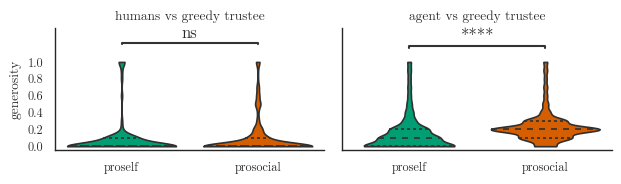

In [32]:
player = args['player']
opponent = args['opponent']
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player==@player & opponent==@opponent')
tTestAndPlot(emp, sim, args, 'generosity')

In [34]:
generalizePlot(pop, sim, args)

# DQN vs Generous Trustee

In [26]:
f = open('fixed_space_pop.json')
params = json.load(f)
# params2 = {
#     "popSeed": 690,
#     "tau": 9.4,
#     "alpha": 0.1299,
#     "gamma": 0.2
# }
# params2 = {
#     "popSeed": 89,
#     "tau": 10.200000000000001,
#     "alpha": 0.054,
#     "gamma": 0.34
# }
# params2 = {
#     "popSeed": 76,
#     "thrSVO": 0.33,
#     "tau": 10.4,
#     "alpha": 0.195,
#     "gamma": 0.77
# }
# params2 = {
#     "popSeed": 76,
#     "thrSVO": 0.31,
#     "tau": 6.2,
#     "alpha": 0.278,
#     "gamma": 0.23
# }
params2 = {
    "popSeed": 89,
    "thrSVO": 0.33,
    "tau": 12.100000000000001,
    "alpha": 0.043000000000000003,
    "gamma": 0.34
}
args = params | params2
agents = makePopulation(args)
IDs = [agent.ID for agent in agents]
player = args['player']
player2 = 'investor' if player=='trustee' else 'trustee'
opponent = args['opponent']
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player==@player & opponent==@opponent')

In [27]:
data = rerun(agents, args)

test 0


105 agents selected
proself 57, prosocial 48
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:5.268e-10 t=-6.361e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:3.209e-23 t=-1.009e+01


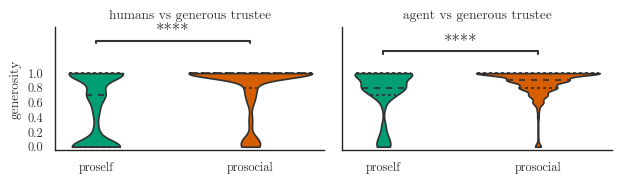

In [28]:
pop, selected = selectLearners(agents, data)
sim, nProself, nProsocial = addLabel(pop, selected, args)
print(f"proself {nProself}, prosocial {nProsocial}")
tTestAndPlot(emp, sim, args, 'generosity')

In [29]:
overlapProself = overlap(emp.query("orientation=='proself'"), sim.query("orientation=='proself'"), args)
overlapProsocial = overlap(emp.query("orientation=='prosocial'"), sim.query("orientation=='prosocial'"), args)
penalty = 1 - overlap(sim.query("orientation=='proself'"), sim.query("orientation=='prosocial'"), args)
print(overlapProself)
print(overlapProsocial)
print(args['penalizeSimilarity']*penalty)

0.27268170426065164
0.225
0.07695175438596491


In [30]:
LTPlot(pop, sim, args)

In [31]:
sim.to_pickle(f"data/{params['architecture']}_vs_{opponent}_{player2}_violin.pkl")

# IBL vs Generous Trustee

In [40]:
f = open('fixed_space_pop.json')
params = json.load(f)
params2 = {
    "popSeed": 10,
    "thrSVO": 0.23,
    "tau": 1.6,
    "decay": 1.35,
    "sigma": 0.62,
    "thrA": -1.48,
    "gamma": 0.29
}
args = params | params2
agents = makePopulation(args)
IDs = [agent.ID for agent in agents]
player = args['player']
player2 = 'investor' if player=='trustee' else 'trustee'
opponent = args['opponent']
emp = pd.read_pickle("data/human_data_cleaned.pkl").query('player==@player & opponent==@opponent')

In [41]:
data = rerun(agents, args)

test 0


118 agents selected
proself 34, prosocial 84
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:5.268e-10 t=-6.361e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proself vs. prosocial: t-test independent samples, P_val:4.251e-12 t=-6.977e+00


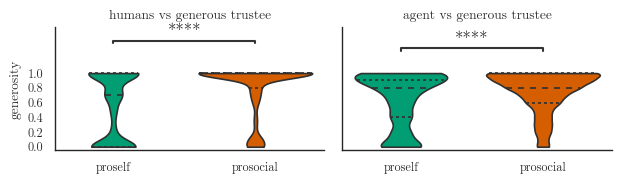

In [42]:
pop, selected = selectLearners(agents, data)
sim, nProself, nProsocial = addLabel(pop, selected, args)
print(f"proself {nProself}, prosocial {nProsocial}")
tTestAndPlot(emp, sim, args, 'generosity')

In [43]:
overlapProself = overlap(emp.query("orientation=='proself'"), sim.query("orientation=='proself'"), args)
overlapProsocial = overlap(emp.query("orientation=='prosocial'"), sim.query("orientation=='prosocial'"), args)
penalty = 1 - overlap(sim.query("orientation=='proself'"), sim.query("orientation=='prosocial'"), args)
print(overlapProself)
print(overlapProsocial)
print(args['penalizeSimilarity']*penalty)

0.2222689075630252
0.4226190476190476
0.12605042016806722
